In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dataloader import *
import os
from tqdm import tqdm

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
print(tf.__version__)
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print(physical_devices)
# tf.config.gpu.set_per_process_memory_fraction(0.1)
# tf.config.gpu.set_per_process_memory_growth(True)
# K.tensorflow_backend.set_session(tf.Session(config=config))

2.3.0


In [3]:
# import nvstatsrecorder

In [4]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [22]:
# tf.config.experimental.list_physical_devices('GPU')

In [23]:
# tf.test.is_gpu_available()

In [3]:
# import tensorflow as tf
# tf.config.experimental.gpu.set_per_process_memory_fraction(0.75)
# tf.config.experimental.gpu.set_per_process_memory_growth(True)
GPU_ID = 2
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    tf.config.experimental.set_visible_devices(gpus[GPU_ID], 'GPU')

#     for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpus[GPU_ID], True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

4 Physical GPUs, 1 Logical GPUs


In [4]:
k_shot=7
k_shot_2=7*2

In [5]:
# d =  DataGenerator(dataset_csv='/home/dataset_10_31_2020_3903_clustered.csv',
#                    pano_directory='/home/data2/pano_image',
#                    label_directory='/home/data2/labels',
#                    num_classes=1,
#                    num_samples_per_class=2*2,
#                    num_meta_test_classes=1,
#                    num_meta_test_samples_per_class=3*2,#3-shot test
#                    IMG_WIDTH=48,
#                    IMG_HEIGHT=48,
#                    num_circles=3)
d = DataGenerator(dataset_csv='/home/dataset_10_31_2020_3903_clustered.csv',
                 pano_directory='/home/data2/pano_image',
                 label_directory='/home/data2/labels',
                 num_classes=1,
                 num_samples_per_class=k_shot_2,#2-shot
                 num_meta_test_classes=1,
                 num_meta_test_samples_per_class=3*2,#3-shot test
                 IMG_WIDTH=48,
                 IMG_HEIGHT=48,
                 num_circles=2,
                 clustered=True,
                 country_code=None)


In [6]:

images,labels = d.sample_batch('meta_train',16)

print(images.shape)
print(labels.shape)
b,n,k,w,h,c = images.shape
images = images.reshape((b*n*k,w,h,c))
labels = labels.reshape((b*n*k,w,h,1))

(16, 1, 72, 48, 48, 3)
(16, 1, 72, 48, 48, 1)


In [7]:
# images[0][0].shape

In [7]:
# from segmentation_models import Unet
import segmentation_models as sm
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
# from segmentation_models.losses import bce_dice_loss
from segmentation_models.metrics import iou_score


BACKBONE='mobilenet'
preprocess_input = get_preprocessing(BACKBONE)
# model = Unet(BACKBONE, encoder_weights='imagenet')

Segmentation Models: using `tf.keras` framework.


In [8]:
# model.m.layers[2].bias

In [9]:
def get_unet(img_rows,img_cols):
    inputs = tf.keras.layers.Input((img_rows, img_cols, 3))
    # tf.keras.layers.SeparableConv2D(fil)
    conv1 = tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.SeparableConv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.SeparableConv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = tf.keras.layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = tf.keras.layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = tf.keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = tf.keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 =tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 =tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 =tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 =tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 =tf.keras.layers.SeparableConv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    # model.compile(optimizer=tfAdam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [9]:
# m=get_unet(48,48)
# m.summary()

In [10]:
# !apt-get install gcc python3-dev -y

In [11]:
# !pip install nvstatsrecorder

In [12]:
# for i in range(len(m.trainable_weights)):
#     print(m.trainable_weights[i].name)

In [13]:
# for j in range(len(m.layers)):
#             print(j,m.layers[j].name)
            
#             if j not in [0,3,6,9,12,16,20,24,28]:
#                 if j in [15,19,23,27]:
#                     print(j,m.layers[j].kernel.name,m.layers[j].bias.name)
#                 else:
#                     print(j,m.layers[j].name,m.layers[j].depthwise_kernel.name,m.layers[j].pointwise_kernel.name,m.layers[j].bias.name)

In [13]:
# for layer in model.trainable_weights:
#     print(layer.name,layer.shape)
    # print(w.shape)

In [14]:
# for layer in model.trainable_weights:
#     print(layer.name,layer.shape)

In [15]:
# model.m.layers[2].weights

In [10]:
# from segmentation_models import Unet
import segmentation_models as sm
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss

# from segmentation_models.losses import bce_dice_loss
# iou_score = sm.metrics.IOUScore()
# iou_score = sm.metrics.FScore()
# sm.metrics.FScore
# preprocess_input = get_preprocessing('mobilenet')

weights = [0.1,0.9]
# bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
dice_loss =sm.losses.DiceLoss(class_weights=np.array([0.1,0.9]))
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (0.5 * focal_loss)
iou_score = tf.keras.metrics.MeanIoU(num_classes=2)

from functools import partial

def copy_model_fn(mi,width,height):
    copied_model = get_unet(width,height)
    copied_model.set_weights(mi.get_weights())
    return copied_model

class MAML_UNet(tf.keras.Model):
    def __init__(self,
                 model_weights,
                 width=1,
                 height=1,
                 num_inner_updates=1,
                 inner_update_lr=0.4,
                 k_shot=5,
                 backbone='mobilenet',
                 pretrain=False):
        '''
        '''
        super(MAML_UNet, self).__init__()
        self.width = width
        self.height = height
        self.inner_update_lr = inner_update_lr
        self.get_preprocessing = get_preprocessing
        self.iou_score = iou_score
        self.BACKBONE = backbone
        self.pretrain = pretrain
        self.loss_func = total_loss
        self.preprocess_input = get_preprocessing(self.BACKBONE)
        if self.pretrain:
            print(self.width,self.height)
            self.m = get_unet(self.width,self.height)
            self.m.load_weights(model_weights)
            print("Loaded weights from: {}".format(model_weights))
        else:
            self.m = get_unet(self.width,self.height)


        # outputs_ts[i] and losses_ts_post[i] are the output and loss after i+1 inner gradient updates
        losses_tr_pre, outputs_tr, losses_ts_post, outputs_ts = [], [], [], []
        accuracies_tr_pre, accuracies_ts = [], []

        # for each loop in the inner training loop
        outputs_ts = [[]]*num_inner_updates
        losses_ts_post = [[]]*num_inner_updates
        accuracies_ts = [[]]*num_inner_updates

        self.kernels = []
        self.biases = []
        '''
        for j in range(len(self.m.layers)):
            # print(j,m.layers[j].name,copied_model.layers[j].name)
            
            if j not in [0,3,6,9,12,16,20,24,28]:
                # print(j,copied_model.layers[j].name)
                # print(j,k,copied_model.layers[j].kernel.shape,m.layers[j].kernel.shape,grads[k].shape)
                # print(j,k+1,copied_model.layers[j].bias.shape,m.layers[j].bias.shape,grads[k+1].shape)
                # print(j,copied_model.layers[j].bias.name,copied_model.layers[j].bias.shape)
                # print(j,copied_model.layers[j].kernel.name,m.layers[j].kernel.shape)
                # print(grads[k].shape)
                self.kernels.append(self.m.layers[j].kernel)
                self.biases.append(self.m.layers[j].bias)
        '''

        # self.copied_model = copy_model_fn(self.m,self.width,self.height)
#     @tf.function
    def call(self,
             inp,
             meta_batch_size=25,
             num_inner_updates=1):
        def task_inner_loop(inp,reuse=True,meta_batch_size=25,num_inner_updates=1):
            '''
            '''
            # the inner and outer loop data
            # query set: (input_tr,label_tr)
            input_tr, input_ts, label_tr, label_ts = inp

            # weights corresponds to the initial weights in MAML (i.e. the meta-parameters)
            # weights = self.w

            # the predicted outputs, loss values, and accuracy for the pre-update model (with the initial weights)
            # evaluated on the inner loop training data
            task_output_tr_pre, task_loss_tr_pre, task_accuracy_tr_pre = None, None, None

            # lists to keep track of outputs, losses, and accuracies of test data for each inner_update
            # where task_outputs_ts[i], task_losses_ts[i], task_accuracies_ts[i] are the output, loss, and accuracy
            # after i+1 inner gradient updates
            task_outputs_ts, task_losses_ts, task_accuracies_ts = [], [], []
            # model = Unet(self.BACKBONE, encoder_weights=None)
            # for i in range(len(model.trainable_weights)):
            #     model.trainable_weights[i].assign(weights[i])
                
            # model = copy_model_fn(self.m,input_tr) 
            # model(input_tr)
            # copy_model(input_tr)
            ######################################
            ############### MAML #################
            # copied_model = copy_model_fn(self.m,self.width,self.height)
            
            with tf.GradientTape(persistent=True) as tape:
                # print(input_tr.shape)
                # tape.watch(model.trainable_weights)
                copied_model = copy_model_fn(self.m,self.width,self.height)
#                 tape.watch(copied_model.trainable_weights)
                task_output_tr_pre = copied_model(input_tr)# logits
                # print(len(self.copied_model.layers))
                task_loss_tr_pre = self.loss_func(label_tr,task_output_tr_pre)
                grads = tape.gradient(task_loss_tr_pre,copied_model.trainable_weights)
                
                '''
                for j in range(len(self.m.layers)):
                    # print(j,m.layers[j].name,copied_model.layers[j].name)
                    
                    if j not in [0,3,6,9,12,16,20,24,28]:
                        # print(j,len(self.m.layers),len(self.copied_model.layers),len(grads),self.m.layers[j].name,self.copied_model.layers[j].name)
                        # print(j,k,copied_model.layers[j].kernel.shape,m.layers[j].kernel.shape,grads[k].shape)
                        # print(j,k+1,copied_model.layers[j].bias.shape,m.layers[j].bias.shape,grads[k+1].shape)
                        # print(j,copied_model.layers[j].bias.name,copied_model.layers[j].bias.shape)
                        # print(j,copied_model.layers[j].kernel.name,m.layers[j].kernel.shape)
                        # print(grads[k].shape)
                        copied_model.layers[j].kernel = self.m.layers[j].kernel - self.inner_update_lr*grads[k]
                        copied_model.layers[j].bias = self.m.layers[j].bias - self.inner_update_lr*grads[k+1]
                        k+=2
                '''
#                 for i in range(len(copied_model.trainable_weights)):
#                     copied_model.trainable_weights[i] = self.m.trainable_weights[i]-self.inner_update_lr*grads[i]
                k=0
                for j in range(len(self.m.layers)):
                    # print(j,m.layers[j].name)
                    
                    if j not in [0,3,6,9,12,16,20,24,28]:
                        if j in [15,19,23,27]:
                            # print(j,m.layers[j].kernel.name,m.layers[j].bias.name)
#                             print(copied_model.layers[j].kernel.shape)
                            copied_model.layers[j].kernel=self.m.layers[j].kernel - self.inner_update_lr*grads[k]
                            copied_model.layers[j].bias=self.m.layers[j].bias - self.inner_update_lr*grads[k+1]
                            k+=2
#                             print(copied_model.layers[j].kernel.shape)
                            copied_model.layers[j].trainable=True
                        else:
                            # print(j,m.layers[j].name,m.layers[j].depthwise_kernel.name,m.layers[j].pointwise_kernel.name,m.layers[j].bias.name)
                            copied_model.layers[j].depthwise_kernel=self.m.layers[j].depthwise_kernel - self.inner_update_lr*grads[k]
                            copied_model.layers[j].pointwise_kernel=self.m.layers[j].pointwise_kernel - self.inner_update_lr*grads[k+1]
                            copied_model.layers[j].bias=self.m.layers[j].bias - self.inner_update_lr*grads[k+2]
                            k+=3
                            copied_model.layers[j].trainable=True
#                 for j in ra
#                 print("Len of copied weights:")
#                 print("Len of weights: {}".format(len(copied_model.get_weights())))
# #                 copied_model2 = copy_model_fn(copied_model,self.width,self.height)
#                 task_output_tr_pre2 = copied_model(input_tr)# logits
#                 task_loss_tr_pre2 = self.loss_func(label_tr,task_output_tr_pre2)
#                 grads = tape.gradient(task_loss_tr_pre2,copied_model.trainable_weights)
#                 print(len(grads))
# #                 k=0
#                 k=0
#                 for j in range(len(self.m.layers)):
#                     if j not in [0,3,6,9,12,16,20,24,28]:
#                         if j in [15,19,23,27]:
#                             # print(j,m.layers[j].kernel.name,m.layers[j].bias.name)
#                             copied_model.layers2[j].kernel = copied_model.layers[j].kernel - self.inner_update_lr*grads[k]
#                             copied_model.layers2[j].bias = copied_model.layers[j].bias - self.inner_update_lr*grads[k+1]
#                             k+=2
#                         else:
#                             # print(j,m.layers[j].name,m.layers[j].depthwise_kernel.name,m.layers[j].pointwise_kernel.name,m.layers[j].bias.name)
#                             copied_model.layers2[j].depthwise_kernel = copied_model.layers[j].depthwise_kernel - self.inner_update_lr*grads[k]
#                             copied_model.layers2[j].pointwise_kernel = copied_model.layers[j].pointwise_kernel - self.inner_update_lr*grads[k+1]
#                             copied_model.layers2[j].bias = copied_model.layers[j].bias - self.inner_update_lr*grads[k+2]
#                             k+=3

                output_ts = copied_model(input_ts)
                loss_ts = self.loss_func(label_ts,output_ts)
                # tape.stop_recording()
#                 del copied_model
                task_outputs_ts.append(output_ts)
                # print("task_outputs_ts {}".format(task_outputs_ts))#(B,5)
                task_losses_ts.append(loss_ts)
                # if num_inner_updates > 1:
                    # NOTE(ANDREW): tf.keras hack does not work for multiple gradient updates
                    # model.set_weights(fast_weights)
                    # for update in range(num_inner_updates-1):
                    #     outputt = copy_model(input_tr,training=True)
                    #     losss = self.loss_func(label_tr,outputt)
                    #     grads = tape.gradient(losss,copy_model.trainable_weights)

                    #     for j in range(len(model.trainable_weights)):
                    #         copy_model.trainable_weights[j] = copy_model.trainable_weights[j] - self.inner_update_lr*grads[j]
                        
                    #     outputtt = copy_model(input_ts,training=True)
                    #     task_outputs_ts.append(outputtt)
                    #     task_losses_ts.append(self.loss_func(label_ts,outputtt))
            # Compute accuracies from output predictions
            task_accuracy_tr_pre = self.iou_score(label_tr,task_output_tr_pre)

            for j in range(num_inner_updates):
                task_accuracies_ts.append(self.iou_score(label_ts,task_outputs_ts[j]))

            task_output = [task_output_tr_pre, task_outputs_ts, task_loss_tr_pre, task_losses_ts, task_accuracy_tr_pre, task_accuracies_ts]

            return task_output

        out_dtype = [tf.float32, [tf.float32]*num_inner_updates, tf.float32, [tf.float32]*num_inner_updates]
        out_dtype.extend([tf.float32, [tf.float32]*num_inner_updates])
        task_inner_loop_partial = partial(task_inner_loop, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
        result = tf.map_fn(task_inner_loop_partial,
                        elems=(input_tr, input_ts, label_tr, label_ts),
                        dtype=out_dtype,
                        parallel_iterations=meta_batch_size)
        return result





        

In [11]:
 model = MAML_UNet('pre-trained-unet-48.h5',
                 width=48,
                 height=48,
                 num_inner_updates=1,
                 inner_update_lr=0.4,
                 k_shot=k_shot_2,
                 backbone='mobilenet',
                 pretrain=True)

48 48
Loaded weights from: pre-trained-unet-48.h5


In [16]:
# model.m.load_weights('MAML_unet_final.h5')

In [18]:
# import gc
# # import tensorflow as tf
# from tensorflow.keras import backend as K
# K.clear_session()
# gc.collect()
# del model

In [11]:
# im = images[0][0]
# l = labels[0][0]
print(images.shape,labels.shape)
im = model.preprocess_input(images)
preds_val = model.m.predict(im)
preds_val_t = (preds_val > 0.5)

(96, 48, 48, 3) (96, 48, 48, 1)


In [18]:
# im[0].shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

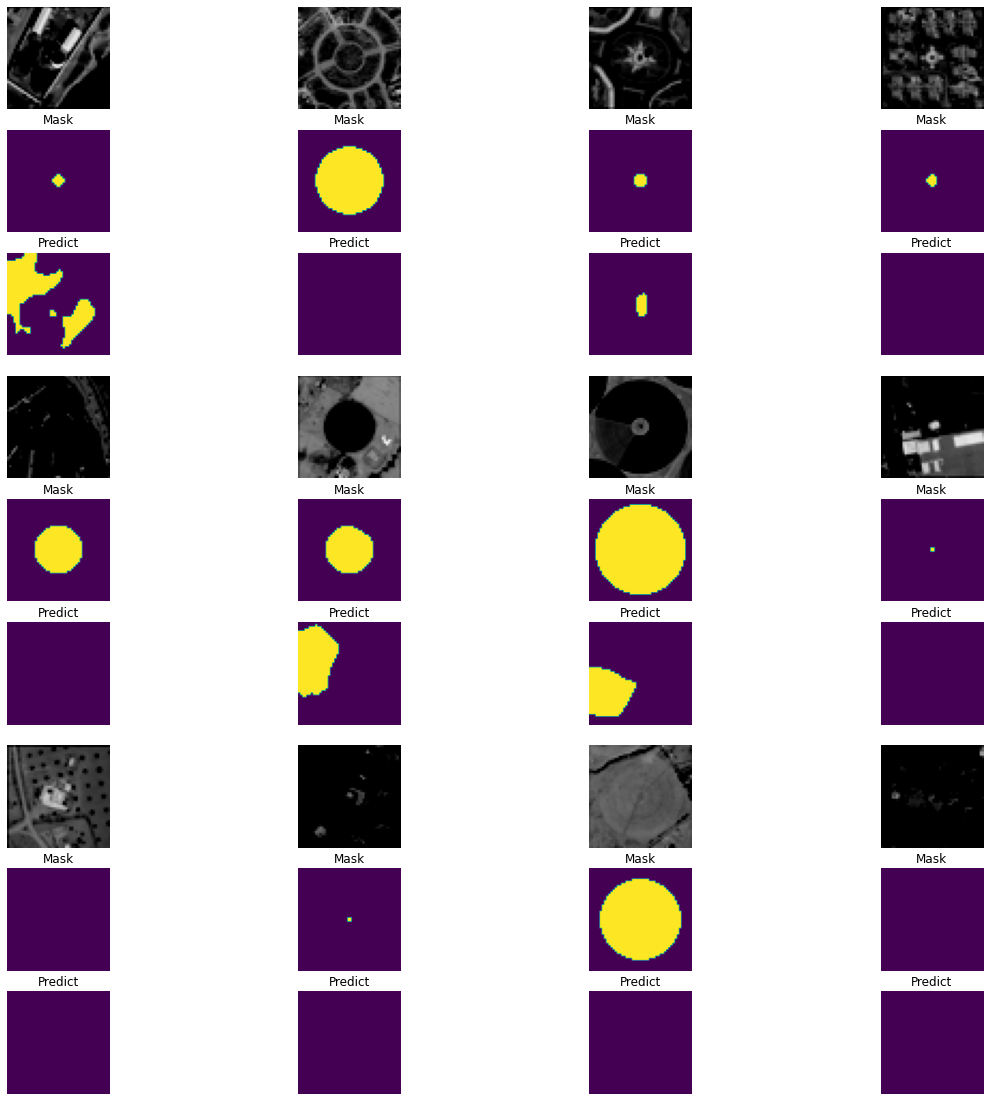

In [12]:
plt.figure(figsize=(20,20))
x, y = 4,3 #cols, rows
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(im[pos])
        #plt.title('Image #{}\nIOU {}'.format(pos,round(cal_iou(np.squeeze(Y_val[pos]), np.squeeze(preds_val_t[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(labels[pos]))
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(preds_val_t[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()

In [22]:
# images,
k_shot=2
images,labels = d.sample_batch('meta_train',8)
b,n,k,w,h,c = images.shape
print(b,n,k,w,h,c)
images = images.reshape((b,n*k,w,h,c))
print("images: {}".format(images.shape))
labels = labels.reshape((b,n*k,w,h,1))

input_tr  = images[:,:k_shot]
label_tr = labels[:,:k_shot]
input_ts = images[:,k_shot:]
label_ts = labels[:,k_shot:]

input_tr = preprocess_input(input_tr)
input_tr = tf.convert_to_tensor(input_tr,tf.float32)
input_ts = preprocess_input(input_ts)
input_ts = tf.convert_to_tensor(input_ts,tf.float32)

label_tr = tf.convert_to_tensor(label_tr,tf.float32)
label_ts = tf.convert_to_tensor(label_ts,tf.float32)
inp = (input_tr, input_ts, label_tr, label_ts)
# result = model(inp, meta_batch_size=16, num_inner_updates=1)

8 1 4 48 48 3
images: (8, 4, 48, 48, 3)


In [12]:
# model.m.trainable_variables
from time import time

In [13]:
import gc
def outer_train_step(inp, model, optim, meta_batch_size=25, num_inner_updates=1):
  # note here, outer tape constructed to watch all model.trainable_variables!
  # inner_loop is called in model(...)
  # no need to do persistent, since only 1 outer_tape.gradient needs to be called
  with tf.GradientTape(persistent=False) as outer_tape:
    result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result

    total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]
  # dont need to update self.inner_update_lr_dict,
  # since learn rate is part of the model.training_variables
  gradients = outer_tape.gradient(total_losses_ts[-1], model.m.trainable_weights)
  # this will update ALL PARAMETERS, including the LEARN RATE!
  # rather than manual gradient descent, Adam (adaptive grad descent) used to update params
  optim.apply_gradients(zip(gradients, model.m.trainable_weights))
  # tf.keras.backend.clear_session()
  # gc.collect()
  total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
  total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
  total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]
  # tf.keras.backend.clear_session()
  return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts

def outer_eval_step(inp, model, meta_batch_size=25, num_inner_updates=1):
  result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

  outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result

  total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
  total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]

  total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
  total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]
  # tf.keras.backend.clear_session()
  # gc.collect()
  return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# t0 = time()
# result = outer_train_step(inp, model, optimizer, meta_batch_size=8, num_inner_updates=1)
# print("Time: {}".format(time()-t0))

In [14]:
from tqdm import tqdm
pre_accuracies, post_accuracies = [], []
val_post_accs = []
SUMMARY_INTERVAL = 2
SAVE_INTERVAL = 5
PRINT_INTERVAL = 10
# TEST_PRINT_INTERVAL = PRINT_INTERVAL*5
TEST_PRINT_INTERVAL = 10

batch_size = 7
num_inner_updates = 1
meta_train_iterations = 200

# from nvstatsrecorder.recorders import NVStatsRecorder, NVLinkStatsRecorder

# # initialize recorders
# nv_stats_recorder = NVStatsRecorder(gpu_index=0)
# nvlink_stats_recorder = NVLinkStatsRecorder('lgs', gpus=[0,1,2,3])

# # start recorders
# nv_stats_recorder.start(interval=1)
# nvlink_stats_recorder.start(interval=1)


for itr in tqdm(range(meta_train_iterations)):

#     k_shot=2
    images,labels = d.sample_batch('meta_train',batch_size)
    b,n,k,w,h,c = images.shape
    # print(b,n,k,w,h,c)
    images = images.reshape((b,n*k,w,h,c))
    # print("images: {}".format(images.shape))
    labels = labels.reshape((b,n*k,w,h,1))

    input_tr  = images[:,:k_shot]
    label_tr = labels[:,:k_shot]
    input_ts = images[:,k_shot:]
    label_ts = labels[:,k_shot:]

    input_tr = preprocess_input(input_tr)
    input_tr = tf.convert_to_tensor(input_tr,tf.float32)
    input_ts = preprocess_input(input_ts)
    input_ts = tf.convert_to_tensor(input_ts,tf.float32)

    label_tr = tf.convert_to_tensor(label_tr,tf.float32)
    label_ts = tf.convert_to_tensor(label_ts,tf.float32)
    inp = (input_tr, input_ts, label_tr, label_ts)
    
    result = outer_train_step(inp, model, optimizer, meta_batch_size=batch_size, num_inner_updates=num_inner_updates)
    # gc.collect()
    if itr % SUMMARY_INTERVAL == 0:
      pre_accuracies.append(result[-2])
      post_accuracies.append(result[-1][-1])

    if (itr!=0) and itr % PRINT_INTERVAL == 0:
      print_str = 'Iteration %d: pre-inner-loop train accuracy: %.5f, post-inner-loop test accuracy: %.5f' % (itr, np.mean(pre_accuracies), np.mean(post_accuracies))
      print(print_str)
      model.m.save_weights('MAML_unet_final.h5')
      # pre_accuracies, post_accuracies = [], []
    if (itr!=0) and itr % TEST_PRINT_INTERVAL == 0:
#         k_shot=2
        images,labels = d.sample_batch('meta_eval',batch_size)
        b,n,k,w,h,c = images.shape
        # print(b,n,k,w,h,c)
        images = images.reshape((b,n*k,w,h,c))
        # print("images: {}".format(images.shape))
        labels = labels.reshape((b,n*k,w,h,1))

        input_tr  = images[:,:k_shot]
        label_tr = labels[:,:k_shot]
        input_ts = images[:,k_shot:]
        label_ts = labels[:,k_shot:]

        input_tr = preprocess_input(input_tr)
        input_tr = tf.convert_to_tensor(input_tr,tf.float32)
        input_ts = preprocess_input(input_ts)
        input_ts = tf.convert_to_tensor(input_ts,tf.float32)

        label_tr = tf.convert_to_tensor(label_tr,tf.float32)
        label_ts = tf.convert_to_tensor(label_ts,tf.float32)
        inp = (input_tr, input_ts, label_tr, label_ts)
        result = outer_eval_step(inp, model, meta_batch_size=batch_size, num_inner_updates=num_inner_updates)
        val_post_accs.append(result[-1][-1])
        print('Meta-validation pre-inner-loop train accuracy: %.5f, meta-validation post-inner-loop test accuracy: %.5f' % (result[-2], result[-1][-1]))

# stop recorders
# nv_stats_recorder.stop()
# nvlink_stats_recorder.stop()

# # get data from recorders
# gpu_data = nv_stats_recorder.get_data()
# # nvlink_data = nvlink_stats_recorder.get_data()
# nv_stats_recorder.plot_gpu_util(smooth=3)
# nvlink_stats_recorder.plot_nvlink_traffic(smooth=3)
    # return post_accuracies
#   model_file = '.' + '/' +'model' + str(itr)
#   print("Saving to ", model_file)
#   model.save_weights(model_file)


  0%|          | 0/200 [00:00<?, ?it/s]

  5%|▌         | 10/200 [00:59<15:17,  4.83s/it] 

Iteration 10: pre-inner-loop train accuracy: 0.46319, post-inner-loop test accuracy: 0.46087


  6%|▌         | 11/200 [01:17<27:49,  8.84s/it]

Meta-validation pre-inner-loop train accuracy: 0.48986, meta-validation post-inner-loop test accuracy: 0.48986


 10%|█         | 20/200 [01:54<12:50,  4.28s/it]

Iteration 20: pre-inner-loop train accuracy: 0.47603, post-inner-loop test accuracy: 0.47478


 10%|█         | 21/200 [02:02<16:02,  5.38s/it]

Meta-validation pre-inner-loop train accuracy: 0.49211, meta-validation post-inner-loop test accuracy: 0.49211


 15%|█▌        | 30/200 [02:38<11:23,  4.02s/it]

Iteration 30: pre-inner-loop train accuracy: 0.48123, post-inner-loop test accuracy: 0.48037


 16%|█▌        | 31/200 [02:46<14:46,  5.25s/it]

Meta-validation pre-inner-loop train accuracy: 0.49285, meta-validation post-inner-loop test accuracy: 0.49285


 20%|██        | 40/200 [03:22<10:43,  4.02s/it]

Iteration 40: pre-inner-loop train accuracy: 0.48401, post-inner-loop test accuracy: 0.48336


 20%|██        | 41/200 [03:29<12:38,  4.77s/it]

Meta-validation pre-inner-loop train accuracy: 0.49293, meta-validation post-inner-loop test accuracy: 0.49293


 25%|██▌       | 50/200 [04:05<09:57,  3.98s/it]

Iteration 50: pre-inner-loop train accuracy: 0.48575, post-inner-loop test accuracy: 0.48523


 26%|██▌       | 51/200 [04:12<12:04,  4.86s/it]

Meta-validation pre-inner-loop train accuracy: 0.49311, meta-validation post-inner-loop test accuracy: 0.49311


 30%|███       | 60/200 [04:48<09:19,  4.00s/it]

Iteration 60: pre-inner-loop train accuracy: 0.48694, post-inner-loop test accuracy: 0.48651


 30%|███       | 61/200 [04:56<12:24,  5.35s/it]

Meta-validation pre-inner-loop train accuracy: 0.49311, meta-validation post-inner-loop test accuracy: 0.49311


 35%|███▌      | 70/200 [05:32<08:48,  4.07s/it]

Iteration 70: pre-inner-loop train accuracy: 0.48780, post-inner-loop test accuracy: 0.48742


 36%|███▌      | 71/200 [05:40<10:59,  5.12s/it]

Meta-validation pre-inner-loop train accuracy: 0.49308, meta-validation post-inner-loop test accuracy: 0.49308


 40%|████      | 80/200 [06:17<08:13,  4.11s/it]

Iteration 80: pre-inner-loop train accuracy: 0.48844, post-inner-loop test accuracy: 0.48811


 40%|████      | 81/200 [06:24<10:12,  5.15s/it]

Meta-validation pre-inner-loop train accuracy: 0.49304, meta-validation post-inner-loop test accuracy: 0.49304


 45%|████▌     | 90/200 [07:02<07:37,  4.16s/it]

Iteration 90: pre-inner-loop train accuracy: 0.48894, post-inner-loop test accuracy: 0.48864


 46%|████▌     | 91/200 [07:08<08:53,  4.89s/it]

Meta-validation pre-inner-loop train accuracy: 0.49305, meta-validation post-inner-loop test accuracy: 0.49305


 50%|█████     | 100/200 [07:44<06:46,  4.07s/it]

Iteration 100: pre-inner-loop train accuracy: 0.48935, post-inner-loop test accuracy: 0.48908


 50%|█████     | 101/200 [07:52<08:32,  5.18s/it]

Meta-validation pre-inner-loop train accuracy: 0.49305, meta-validation post-inner-loop test accuracy: 0.49305


 55%|█████▌    | 110/200 [08:29<06:03,  4.04s/it]

Iteration 110: pre-inner-loop train accuracy: 0.48968, post-inner-loop test accuracy: 0.48944


 56%|█████▌    | 111/200 [08:38<07:54,  5.33s/it]

Meta-validation pre-inner-loop train accuracy: 0.49300, meta-validation post-inner-loop test accuracy: 0.49300


 60%|██████    | 120/200 [09:14<05:25,  4.06s/it]

Iteration 120: pre-inner-loop train accuracy: 0.48995, post-inner-loop test accuracy: 0.48973


 60%|██████    | 121/200 [09:23<07:24,  5.63s/it]

Meta-validation pre-inner-loop train accuracy: 0.49296, meta-validation post-inner-loop test accuracy: 0.49296


 65%|██████▌   | 130/200 [09:59<04:46,  4.10s/it]

Iteration 130: pre-inner-loop train accuracy: 0.49018, post-inner-loop test accuracy: 0.48998


 66%|██████▌   | 131/200 [10:07<05:53,  5.12s/it]

Meta-validation pre-inner-loop train accuracy: 0.49319, meta-validation post-inner-loop test accuracy: 0.49319


 70%|███████   | 140/200 [10:43<04:06,  4.11s/it]

Iteration 140: pre-inner-loop train accuracy: 0.49039, post-inner-loop test accuracy: 0.49020


 70%|███████   | 141/200 [10:50<05:00,  5.09s/it]

Meta-validation pre-inner-loop train accuracy: 0.49316, meta-validation post-inner-loop test accuracy: 0.49316


 75%|███████▌  | 150/200 [11:29<03:27,  4.14s/it]

Iteration 150: pre-inner-loop train accuracy: 0.49057, post-inner-loop test accuracy: 0.49040


 76%|███████▌  | 151/200 [11:36<04:13,  5.17s/it]

Meta-validation pre-inner-loop train accuracy: 0.49311, meta-validation post-inner-loop test accuracy: 0.49311


 80%|████████  | 160/200 [12:13<02:42,  4.07s/it]

Iteration 160: pre-inner-loop train accuracy: 0.49073, post-inner-loop test accuracy: 0.49056


 80%|████████  | 161/200 [12:20<03:21,  5.17s/it]

Meta-validation pre-inner-loop train accuracy: 0.49320, meta-validation post-inner-loop test accuracy: 0.49320


 85%|████████▌ | 170/200 [12:58<02:10,  4.35s/it]

Iteration 170: pre-inner-loop train accuracy: 0.49087, post-inner-loop test accuracy: 0.49072


 86%|████████▌ | 171/200 [13:06<02:32,  5.27s/it]

Meta-validation pre-inner-loop train accuracy: 0.49316, meta-validation post-inner-loop test accuracy: 0.49316


 90%|█████████ | 180/200 [13:42<01:21,  4.05s/it]

Iteration 180: pre-inner-loop train accuracy: 0.49100, post-inner-loop test accuracy: 0.49085


 90%|█████████ | 181/200 [13:49<01:34,  4.95s/it]

Meta-validation pre-inner-loop train accuracy: 0.49315, meta-validation post-inner-loop test accuracy: 0.49315


 95%|█████████▌| 190/200 [14:25<00:40,  4.06s/it]

Iteration 190: pre-inner-loop train accuracy: 0.49111, post-inner-loop test accuracy: 0.49097


 96%|█████████▌| 191/200 [14:33<00:46,  5.20s/it]

Meta-validation pre-inner-loop train accuracy: 0.49311, meta-validation post-inner-loop test accuracy: 0.49311


100%|██████████| 200/200 [15:11<00:00,  4.56s/it]


Text(0.5, 1.0, 'Clustered Split Meta Train K=7 Val Post-Inner Loop Accuracies ')

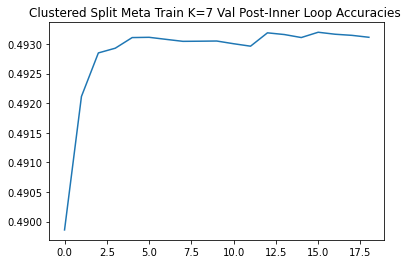

In [15]:
plt.plot(val_post_accs)
plt.title("Clustered Split Meta Train K=7 Val Post-Inner Loop Accuracies ")

In [16]:
model.m.save('cl_k_7_maml_unet_final.h5')

Text(0.5, 1.0, 'Clustered Split Meta Train K=3 Val Post-Inner Loop Accuracies ')

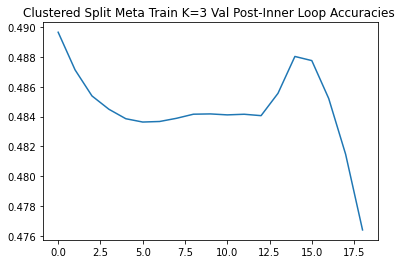

In [14]:
plt.plot(val_post_accs)
plt.title("Clustered Split Meta Train K=3 Val Post-Inner Loop Accuracies ")

In [15]:
model.m.save('cl_k_3_maml_unet_final.h5')

In [ ]:
# model.m.save('k_7_maml_unet_final.h5')

Text(0.5, 1.0, 'Meta Train K=7 Val Post-Inner Loop Accuracies ')

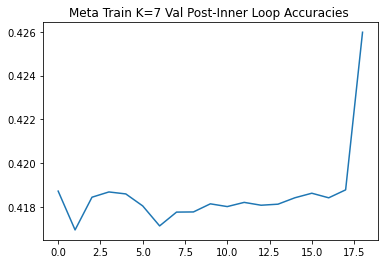

In [15]:
# plt.plot(val_post_accs)
# plt.title("Meta Train K=7 Val Post-Inner Loop Accuracies ")

In [15]:
# model.m.save_weights('k_3_maml_unet_final.h5')

In [14]:
# model.m.load_weights('k_3_maml_unet_final.h5')

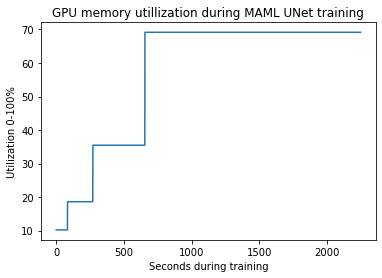

In [19]:
#  plt.plot([round(i,2) for i in gpu_data["mem_occupy_history"]])
# plt.title("GPU memory utillization during MAML UNet training")
# plt.xlabel("Seconds during training")
# plt.ylabel("Utilization 0-100%")
# plt.savefig("GPU memory utillization during MAML UNet training")

In [ ]:
# nv_stats_recorder.plot_gpu_util(smooth=3)
# plt.plot([i for i in gpu_data['mem_occupy_history']])
# nv_stats_recorder.plot_gpu_util(smooth=3)
# trunc = 2 - 1
# t_len = len(gpu_data["time_history"])
# time_history = gpu_data["time_history"][trunc:t_len]
# print([round(i,3) for i in gpu_data["mem_occupy_history"]])
# gpu_data['mem_occupy_history']

Text(0.5, 1.0, 'Meta Train K=3 Val Post-Inner Loop Accuracies ')

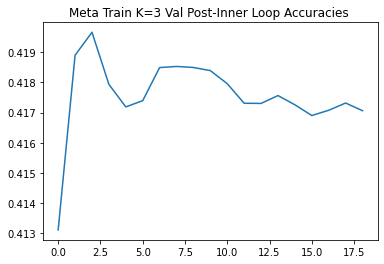

In [15]:
plt.plot(val_post_accs)
plt.title("Meta Train K=3 Val Post-Inner Loop Accuracies ")

In [ ]:
model.m.save_weights('k_3_maml_unet_final.h5')

# Meta Test Function

In [24]:
k_shot

3

In [17]:
np.random.seed(1)
random.seed(1)
meta_batch_size=25
NUM_META_TEST_POINTS = 20
meta_test_accuracies = []
n_way=1
# k_shot=2
for _ in tqdm(range(NUM_META_TEST_POINTS)):
#############################
#### YOUR CODE GOES HERE ####

    # sample a batch of test data and partition into
    # group a (input_tr, label_tr) and group b (input_ts, label_ts)
    images,labels = d.sample_batch('meta_test',
                                  meta_batch_size,
                                  shuffle=False)

#     images,labels = d.sample_batch('meta_eval',batch_size)
    b,n,k,w,h,c = images.shape
#     print(b,n,k,w,h,c)
#     print(labels.shape)
    images = images.reshape((b,n*k,w,h,c))
    # print("images: {}".format(images.shape))
    labels = labels.reshape((b,n*k,w,h,1))

    input_tr  = images[:,:k_shot]
    label_tr = labels[:,:k_shot]
    input_ts = images[:,k_shot:]
    label_ts = labels[:,k_shot:]
    input_tr = preprocess_input(input_tr)
    input_tr = tf.convert_to_tensor(input_tr,tf.float32)
    input_ts = preprocess_input(input_ts)
    input_ts = tf.convert_to_tensor(input_ts,tf.float32)

    label_tr = tf.convert_to_tensor(label_tr,tf.float32)
    label_ts = tf.convert_to_tensor(label_ts,tf.float32)
    # input_ts, label_ts = data_generator.sample_batch('test',meta_batch_size)
    # print("input_tr {},label_tr {}".format(input_tr.shape,label_tr.shape))
    # print("input_ts {},label_ts {}".format(input_ts.shape,label_ts.shape))
    #############################
    inp = (input_tr, input_ts, label_tr, label_ts)
    result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=1)

    meta_test_accuracies.append(result[-1][-1])

meta_test_accuracies = np.array(meta_test_accuracies)
means = np.mean(meta_test_accuracies)
stds = np.std(meta_test_accuracies)
ci95 = 1.96*stds/np.sqrt(NUM_META_TEST_POINTS)

print('Mean meta-test accuracy/loss, stddev, and confidence intervals')
print((means, stds, ci95))


100%|██████████| 20/20 [04:11<00:00, 12.60s/it]

Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.49157405, 0.0008699176, 0.0003812582091296737)


In [21]:
result[-1]

[<tf.Tensor: id=1499152, shape=(), dtype=float32, numpy=0.014979517>]

In [6]:
import tensorflow as tf

print(tf.test.is_gpu_available())


True


In [7]:
tf.__version__

'2.0.0'